# FIT3139 Final Project

## Section 1

### Specification table
|                      |                                                                                                         |
|----------------------|---------------------------------------------------------------------------------------------------------|
| Base Model           | Tennis simulation                                                                                       |
| Extension assumpion  | Simulate a complete season based on skill distribution                                                  |
| Techniques showcaed  | Markov chains, Montecarlo Simulations, Heuristics                                                       |
| Modelling question 1 | How does the skill distribution and initial order of players affect the outcome of a tennis tournament? |
| Modelling question 2 | Comparing initial skill distribution vs win distribution after many tournaments.                        |
| Modelling question 3 | What is more effective in revealing the true quality of players: longer matches or longer tournaments?  |

## Section 2: Introduction

### The problem and the motivation

The primary problem addressed in this project is to understand the impact of skill distribution on player rankings in a tennis season. Additionally, the project aims to determine whether longer matches or longer seasons are more effective in revealing the true quality of players. This problem is motivated by the need to ensure fairness and accuracy in competitive sports, where ranking systems often determine players' career.

### Describe the extension and the questions my model will answer

I'm simulating a tennis match using markov chains. The extension is to simulate a complete season based on skill distribution. The base model discussed earlier used markov chain with "some" probability to move to a next point, which didn't take into account the skill level of a player. This extension will simplify the states in the transition matrix but will add complexity to take into account the player's serving and returning skills. The model will answer the following questions:

1. How does the skill distribution and initial order of players affect the outcome of a tennis tournament?
2. Comparing initial skill distribution vs win distribution after many tournaments.
3. What is more effective in revealing the true quality of players: longer matches or longer tournaments?

This question can be answered using other techniques such as game theory, however I have chosen markov chains as I believe it more accurately models a tennis players' skill level and allows me to examine how players of different skill levels perform in a match and whether they have any liklihood of winning. 
Sports do have a certain level of strategy involved, however given that I am using markov chains I am not considering that in this model and instead assuming that a player will always play the best shot possible, allowing me to focus on the skill level of a player.


## Section 3: Model description

### Model extension details

The base model used a markov chain to simulate a tennis match with equal probability for moving on to the next possible score. The extension will use a markov chain but will take into account the skill level of the players. Each player contains 2 skills - a serve and return skill. These skills will be represented by a number between 0 and 1, where 0 is the lowest skill level and 1 is the highest skill level.

The skill level of a players will be used to create a transition matrix. The creation of the transition matrix is based on the skill level of the 2 provided players.

The skill level will be used to determine the probability of a player winning a point when serving or returning. The skill level will be used to adjust the transition matrix probabilities to reflect the player's skill level. The model aims to simulate a tournament based on the skill distribution of the players but more importantly, to determine how the skill level of a player affects the outcome of a match and to test whether longer matches or longer tournaments are more effective in revealing the true quality of players.

### Model assumptions

#### Base assumptions
1. A tennis match is played between 2 players.
2. Each player has a certain probability of winning a point

#### Extension assumptions
1. The skill level of a player is represented by a number between 0 and 1, where 0 is the lowest skill level and 1 is the highest skill level. This is important for the creation of the transition matrix and to make sure that the probability is always between 0 and 1.
2. The transition matrix used for the model has to be absorbing to ensure that the game ends
3. This model only takes into account the skill level of a player, not the strategies that a player might use in a match. This is to simplify the model and focus on the skill level of a player.

### Class of the model

#### Linear vs Non-linear

In a linear model, outcomes are directly proportional to the inputs, and changes in input variables lead to predictable and proportional changes in output. 
However, in this tennis simulation, the outcome of each match and the progression of the tournament are highly dependent on the interaction between players' skills, which introduces complexity and non-linearity. 
For example, a lower-skilled player can occasionally defeat a higher-skilled player, and this unexpected result can significantly impact subsequent match outcomes and overall rankings.

The use of probabilistic elements introduces non-linearity. The inherent randomness means that small changes in initial conditions (eg: even slight differences in skill levels) can lead to  different outcomes, which are characteristic of non-linear systems.

#### Continuous vs Discrete
##### Why discrete?
The model is discrete as the state space is finite. The model is based on the outcome of each point in a tennis match. The model transitions between these states [serve, return, rally] based on the probability of transitioning to one of these states before stopping at one of the absorbing states where either the server wins or the returner wins. The model is discrete as the outcome of each point is an absolute value decided based on the transition matrices.

##### Why not continuous? 
Simulating a tennis match using a continuous model is not appropriate for answering my questions because I am only interested in the outcome of each point at the lowest level which is either a win or a loss (tennis does not have ties/draws). A continuous model could have been helpful if I was interested in the score of the match at any given point in time.

#### Deterministic vs Stochastic
The model is stochastic as the outcome of each point is determined by a probability distribution. 
Each player has a skill level in terms of serving and returning, which affects the probability of winning a point. 
A higher serving level increases the likelihood of winning a point directly (ace) however, if the opponent has a high returning skill this probability is reduced/normalised to account for the opponent's skill level. 
Each point starts with one of the players serving; from this serving state the model transitions to one of the other possible transient states and the point end when either the server or returner wins a point. Given that each step is probabilistic, the model is stochastic.


### Algorithms being used

- Markov chains is used as the basis for the model
- Montecarlo simulations will be used to understand the general trends created by skill distribution in the model
- Heuristics with the simulated annealing algorithm is used to understand the various 
- Custom function to generate the transition matrix based on the skill level of the players used for the markov chain model

### The rules of tennis

#### Points:
Each game starts with a serve and players alternate serving every game. Points are scored as follows: 0 (Love), 15, 30, 40, and game point.

#### Games:
A player wins a game by scoring four points and leading by at least two points. If the score reaches 40-40, the game is in deuce, and a player must win two consecutive points to win the game.

#### Sets:
A player wins a set by winning six games and leading by at least two games. If the score reaches 6-6, a tiebreaker is played to determine the winner of the set.

#### Match:
A player wins a match by winning the best of three or five sets.


#### Reference to learn more
To learn more about the rules of tennis, visit the [International Tennis Federation Rules and Regulations](https://www.itftennis.com/en/about-us/governance/rules-and-regulations/) or view [2024 Rules of Tennis (English)](https://www.itftennis.com/media/7221/2024-rules-of-tennis-english.pdf).

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from helper import *
from transitionmatrix import *
from simulation import *
from tournament import SingleEliminationTournament
from montecarlo import _monte_carlo_point, _monte_carlo_game, _monte_carlo_set, _monte_carlo_match, plot_monte_carlo_simulation

### Transition matrix example

In my markov chain model, the transition matrix is a 5x5 matrix with the following states/structure:

S1: Serve

S2: Return

S3: Rally

S4: Point won by server

S5: Point won by returner

The transition matrix is as follows:

|    | S1 | S2  | S3  | S4   | S5   |
|----|----|-----|-----|------|------|
| S1 | 0  | 0.6 | 0   | 0.2  | 0.2  |
| S2 | 0  | 0   | 0.7 | 0.15 | 0.15 |
| S3 | 0  | 0   | 0.5 | 025  | 0.25 |
| S4 | 0  | 0   | 0   | 1    | 0    |
| S5 | 0  | 0   | 0   | 0    | 1    |


And in its canonical form:
From this matrix, we can extract the canonical form:

$$
\begin{align*}

\begin{pmatrix}
Q & R \\
0 & I \\
\end{pmatrix} & =

\begin{pmatrix}
0 & 0.6 & 0 & 0.2 & 0.2 \\
0 & 0 & 0.7 & 0.15 & 0.15 \\
0 & 0 & 0.5 & 0.25 & 0.25 \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 \\
\end{pmatrix}

\\

Q & =
\begin{pmatrix}
0 & 0.6 & 0 \\
0 & 0 & 0.7 \\
0 & 0 & 0.5 \\
\end{pmatrix}


& R &=
\begin{pmatrix}
0.2 & 0.2 \\
0.15 & 0.15 \\
0.25 & 0.25 \\
\end{pmatrix}

\\

0 & =
\begin{pmatrix}
0 & 0 & 0 \\
0 & 0 & 0 \\
\end{pmatrix}


& I &=
\begin{pmatrix}
1 & 0 \\
0 & 1 \\
\end{pmatrix}

\end{align*}
$$

Getting the fundamental matrix:

$$
\begin{align*}
& N = (I - Q)^{-1} \\

& N = 
\begin{pmatrix}
1 & -0.6 & 0 \\
0 & 1 & -0.7 \\
0 & 0 & 1 \\
\end{pmatrix}^{-1} \\


\end{align*}
$$

See below for calculations

#### Caluclation for the example transition matrix

In [2]:
M = np.array([
    [0, 0.6, 0, 0.2, 0.2],
    [0, 0, 0.7, 0.15, 0.15],
    [0, 0, 0.5, 0.25, 0.25],
    [0, 0 ,0 ,1, 0],
    [0, 0, 0, 0, 1]
])
D = np.diag(M)
absorbing, transient = np.where(D==1)[0], np.where(D!=1)[0]
print("Absorbing states:", absorbing)  # rows 3 and 4
print("Transient states:", transient)  # rows 0, 1, 2

Absorbing states: [3 4]
Transient states: [0 1 2]


In [3]:
Q = M[:3,:3]
R = M[:3,3:]
N = np.linalg.inv(np.eye(3) - Q) # Fundamental matrix
expected_visits = np.sum(N, axis=1)
least_visitied = transient[np.argmin(expected_visits)]
absorbtion_time = N.dot(np.ones_like(transient))
total_time = np.sum(absorbtion_time)
# Probability of absoption = B_{ij} = NR
absorbtion_probabilities = N.dot(R)  # B = N * R

print("Expected visits:", expected_visits)
print("Least visited state:", least_visitied)
print("Absorbtion time:", absorbtion_time)
print("Total time:", total_time)
print("Absorbtion probabilities:\n", absorbtion_probabilities)

Expected visits: [2.44 2.4  2.  ]
Least visited state: 2
Absorbtion time: [2.44 2.4  2.  ]
Total time: 6.84
Absorbtion probabilities:
 [[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]


The probability of reaching a state $M_{ij}$ in $n$ steps is given by $P_{ij}(n) = M^n_{ij}$

This formula is useful to examine the probability of reaching a state after a certain number of steps.

In [4]:
# calculating P_{ij}^{(n)} = M_{ij}^{(n)}
P = lambda M, n: np.linalg.matrix_power(M, n)

In [5]:
print("P_{ij}^{(1)}:\n", P(M, 1))
print("P_{ij}^{(2)}:\n", P(M, 2))
print("\nMoving to higher powers...\n")

# requires NumPy 1.15.0 or later
with np.printoptions(precision=5, suppress=True):
    print("P_{ij}^{(9)}:\n", P(M, 9))
    print("P_{ij}^{(10)}:\n", P(M, 100))

P_{ij}^{(1)}:
 [[0.   0.6  0.   0.2  0.2 ]
 [0.   0.   0.7  0.15 0.15]
 [0.   0.   0.5  0.25 0.25]
 [0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   1.  ]]
P_{ij}^{(2)}:
 [[0.    0.    0.42  0.29  0.29 ]
 [0.    0.    0.35  0.325 0.325]
 [0.    0.    0.25  0.375 0.375]
 [0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    1.   ]]

Moving to higher powers...

P_{ij}^{(9)}:
 [[0.      0.      0.00328 0.49836 0.49836]
 [0.      0.      0.00273 0.49863 0.49863]
 [0.      0.      0.00195 0.49902 0.49902]
 [0.      0.      0.      1.      0.     ]
 [0.      0.      0.      0.      1.     ]]
P_{ij}^{(10)}:
 [[0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.5 0.5]
 [0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  1. ]]


We can see that as the number of steps increases, the probability of absorbing into either the server or returner winning increases.


$$
\begin{align*}

\lim_{n \to \infty} P_{ij}(n) = M_{ij}^n & = N \cdot R \\

\end{align*}
$$

We can see that this transition matrix will be absorbed since the sum of probabilities of reaching state 3 or 4 (absorbing) from the transient states is 1. This means that the probability of the server or returner winning will be 1.

##### Exploring this property on the important states/domain

There are essentially 3 interesting states to explore. During this exploration, we are assuming that only 1 player is serving and the other is returning, so this is basically the probability of one of the players winning a point.

The 3 interesting states are:
1. The server's skill is higher than the returner's skill
2. The returner's skill is higher than the server's skill
3. The server and returner have the same skill level

Instead of creating a transition matrix by hand, I have created a function that generates a transition matrix based on the skill level of the players. This function will be used to generate the transition matrix for the players in the simulation.

In [6]:
server_skill = 0.8  # High skill server
returner_skill = 0.4  # Moderate skill returner
show_absorbtion_probabilities(server_skill, returner_skill)

[[0.   0.   0.   0.75 0.25]
 [0.   0.   0.   0.75 0.25]
 [0.   0.   0.   0.75 0.25]
 [0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   1.  ]]


Again we can see that the probability of reaching the absorbing states is 1. Hence the transition matrices created using the create_transition_matrix function are also absorbing.

Furthermore, in this domain we set the server skill as 0.8 which is double that of the returner's skill of 0.4. Setting this skill level difference allows reasonably assume that the server will win the point more often than the returner. This is reflected in the transition matrix where the server has a higher probability of winning the point i.e 75% of the time compared to the returner who has a 25% chance of winning the point.

In [7]:
show_absorbtion_probabilities(0.5, 0.5)  # Equal skill levels

[[0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.5 0.5]
 [0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  1. ]]


In [8]:
show_absorbtion_probabilities(0.4, 0.8)  # Low skill server, high skill returner

[[0.   0.   0.   0.25 0.75]
 [0.   0.   0.   0.25 0.75]
 [0.   0.   0.   0.25 0.75]
 [0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   1.  ]]


## Section 4: Results

Again in my analysis I will be looking at the interesting states mentioned earlier - high, low and equal. While this might not be possible for all the different techniques. I will elaborate on the interesting results.

### Markov simulation

In the previous section, it was observed that the transition matrix absorbs into either state with equal probability, hence if the simulation (of points) is run for a long time, it is expected that both players will have approximately equal number of wins. 

The diagram below shows this behaviour, which matches my theory.

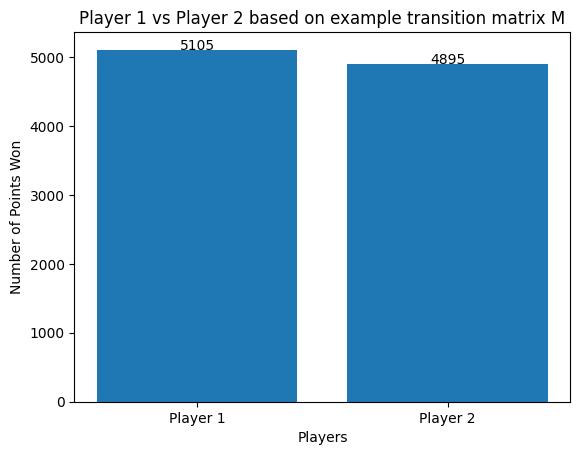

In [9]:
stats = {
    "Player 1": 0,
    "Player 2": 0,
}

for _ in range(10000):
    simulation = simulate_point(M)
    stats["Player 1"] += 1 if simulation[0] == 3 else 0
    stats["Player 2"] += 1 if simulation[0] == 4 else 0

plt.bar(stats.keys(), stats.values())
plt.xlabel("Players")
plt.ylabel("Number of Points Won")
plt.title("Player 1 vs Player 2 based on example transition matrix M")
for key, value in stats.items():
    plt.text(key, value, str(value), ha="center")
plt.show()

Now, let's move towards a set simulation and skew the results towards one of the players by settings the return skill of player 2 to be slightly higher than the serve skill of player 1, while keeping the return skill of player 1 the same as the serve skill of player 2. 

The result below shows the 2 transition matrices one of which has equal probability and the other has a skewed probability towards player 2. The simulation results show that player 2 wins more points than player 1, which is expected given the transition matrices based on initial skill levels.

[[0.      0.      0.      0.45946 0.54054]
 [0.      0.      0.      0.45946 0.54054]
 [0.      0.      0.      0.45946 0.54054]
 [0.      0.      0.      1.      0.     ]
 [0.      0.      0.      0.      1.     ]] 

[[0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.5 0.5]
 [0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  1. ]] 



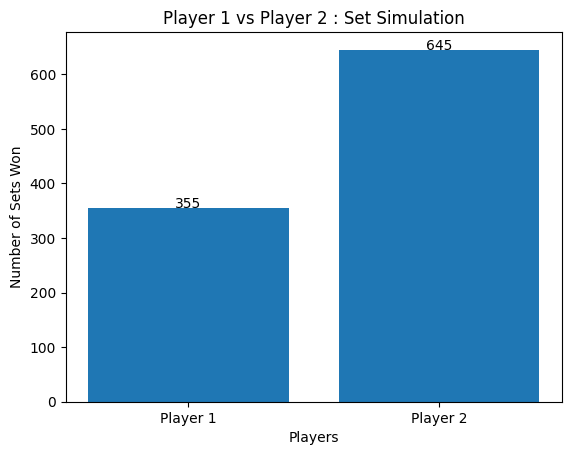

In [10]:
player1 = Player(0.8, 0.4, name="Player 1")
player2 = Player(0.4, 0.83, name="Player 2")

stats = {
    "Player 1": 0,
    "Player 2": 0,
}

transition_matrices = create_transition_matrices(player1, player2)
for M in transition_matrices:
    with np.printoptions(precision=5, suppress=True):
        print(np.linalg.matrix_power(M, 100), "\n")

for _ in range(1000):
    player1_games, player2_games = simulate_set(player1, player2, create_transition_matrices(player1, player2))
    stats["Player 1"] += 1 if player1_games > player2_games else 0
    stats["Player 2"] += 1 if player1_games < player2_games else 0

plt.bar(stats.keys(), stats.values())
plt.xlabel("Players")
plt.ylabel("Number of Sets Won")
plt.title("Player 1 vs Player 2 : Set Simulation")
for key, value in stats.items():
    plt.text(key, value, str(value), ha="center")
plt.show()



#### Answering question 1

Tennis tournaments are generally played in the Single Elimination format. This intuitively means that if 2 strong players meet early in the tournament, one of them will be eliminated early. This is a disadvantage for the tournament as it does not allow the best players to reach the final and why understanding the skill distribution is important.

The following analysis shows that a tournament structure where  the strongest players (1 and 8) are placed at opposite ends of the draw, will result in the strongest players reaching the final and hence resulting in a more predictable outcome where the strongest player wins and players with lower skill levels are ranked accordingly. 

In [320]:
players = [
    Player(0.9, 0.9, name="Player 1"),
    Player(0.2, 0.2, name="Player 2"),
    Player(0.5, 0.5, name="Player 3"),
    Player(0.6, 0.6, name="Player 4"),
    Player(0.4, 0.4, name="Player 5"),
    Player(0.7, 0.7, name="Player 6"),
    Player(0.5, 0.4, name="Player 7"),
    Player(0.8, 0.8, name="Player 8"),
]

tournament = SingleEliminationTournament(players, best_of=3)
top4 = tournament.simulate()
for i, player in enumerate(top4):
    print(f"Rank {i+1}: {player.name} : Serve={player.Serve} : Return={player.Return}")

Rank 1: Player 1 : Serve=0.9 : Return=0.9
Rank 2: Player 8 : Serve=0.8 : Return=0.8
Rank 3: Player 6 : Serve=0.7 : Return=0.7
Rank 4: Player 4 : Serve=0.6 : Return=0.6


This is the other case where strong players meet early in the tournament, this introduces a chance for players with lower skill levels to reach the final. While this is not as predictable as the previous initial condition, this randomness can make the tournament more interesting and exciting for the viewers, and even allow newer players to reach stages of the tournament they might not have reached otherwise.

While the strongest player still wins the tournament in a predictable manner, this randomness introduces a lot more players to the ranking system and can be used to determine the true skill level of a player over a longer period of time with a different model.

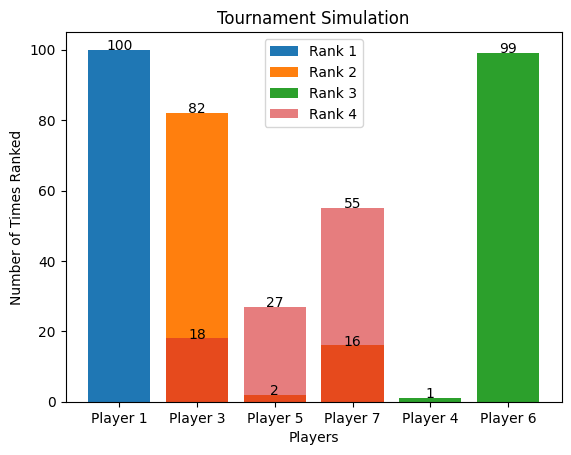

In [321]:
players = [
    Player(0.9, 0.9, name="Player 1"),
    Player(0.8, 0.8, name="Player 8"),
    Player(0.7, 0.7, name="Player 6"),
    Player(0.6, 0.6, name="Player 4"),
    Player(0.5, 0.5, name="Player 3"),
    Player(0.2, 0.2, name="Player 2"),
    Player(0.4, 0.4, name="Player 5"),
    Player(0.5, 0.4, name="Player 7"),
]

simulations = 100
results = []
for i in range(simulations):
    tournament = SingleEliminationTournament(players, best_of=3)
    top4 = tournament.simulate()
    results.append(top4)

# set of players who ranked 1st, 2nd, 3rd and 4th
ranks = np.array([[p.name for p in [item[j] for item in results]] for j in range(4)])
rankings = [dict(zip(*np.unique(ranks[i], return_counts=True))) for i in range(4)] # indexed in order of ranks
fig, ax = plt.subplots()
for i, rank in enumerate(rankings):
    ax.bar(rank.keys(), rank.values(), label=f"Rank {i+1}", alpha=0.6 if i == 3 else 1)
    # label ranks above bar for each player
    for key, value in rank.items():
        ax.text(key, value, str(value), ha="center")
ax.set_xlabel("Players")
ax.set_ylabel("Number of Times Ranked")
ax.set_title("Tournament Simulation")
ax.legend()
plt.show()

#### Answering question 2 - Skill vs win distribution

The following analysis shows that the skill distribution of the players is not the same as the win distribution of the players. This is because the skill distribution is based on the initial skill level of the players, while the win distribution is based on the outcome of the tournament. This is important as it shows that the skill level of a player does not always determine the outcome of a tournament. This is why it is important to have a ranking system that takes into account the win distribution of the players and not just the skill distribution.


In the following graph we can observe that player 8 who has a total skill level of (0.9 + 0.4) has more wins that players 1 and 2 who have a total skill level of (0.8 + 07), this is because players 1 and 2 meet early in the tournament and one of them is hence eliminated early. This is why it is important to have a ranking system that takes into account the win distribution of the players and not just the skill distribution which is where other techniques such as montecarlo simulation and heuristics comes into play.

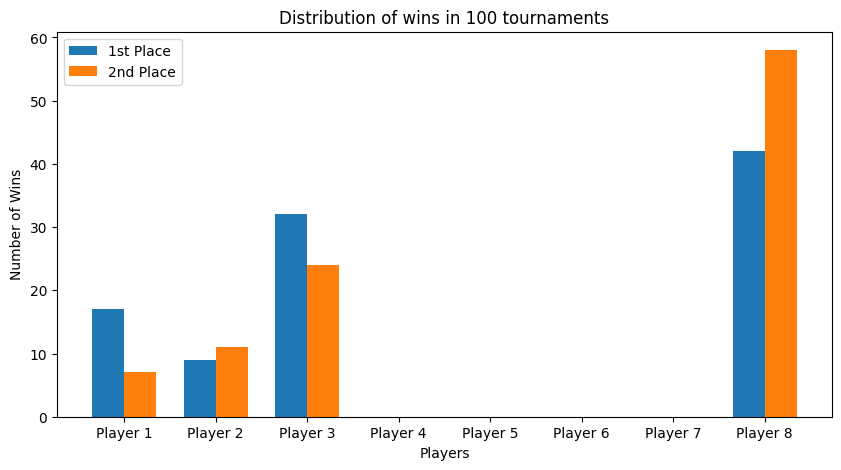

In [347]:
players = [
    Player(0.7, 0.8),
    Player(0.8, 0.7),
    Player(0.4, 0.9),
    Player(0.6, 0.6),
    Player(0.5, 0.5),
    Player(0.6, 0.6),
    Player(0.5, 0.5),
    Player(0.9, 0.4),
]
simulate_tournaments(players, num_tournaments=100)

### Montecarlo simulation

#### Answering question 3

The montecarlo simulation is used to understand how the length of a match affects the outcome.

The first simulation shows what happens if several points are played. The results show that the results skew towards the player who is serving more often. This shows that simply repeating a single point is not sufficient to determine the true skill level of a player.

In [332]:
player1 = Player(0.7, 0.8)
player2 = Player(0.9, 0.3)

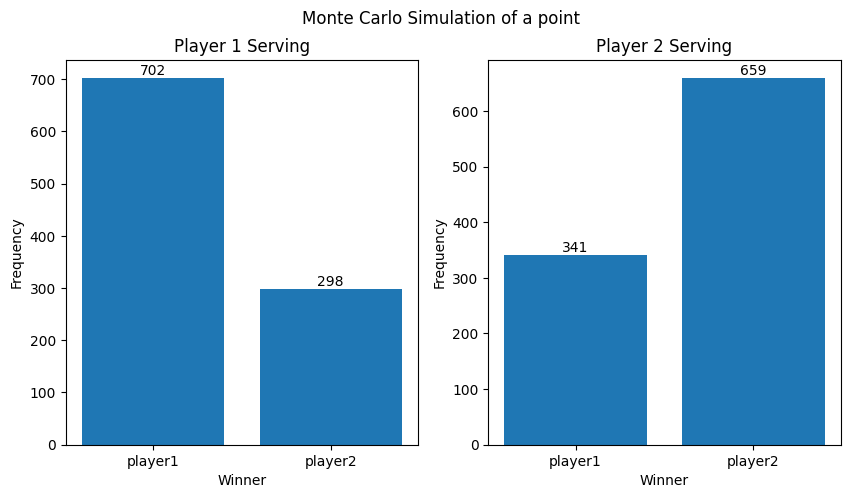

In [333]:
plot_monte_carlo_simulation(player1, player2, _monte_carlo_point)

Next, the simulation is run for several games. This more accurately depicts the expected results because the domain being analysed shows that the total skill level of a player (serve skill + return skill) is higher for player 1 than player 2. However, this result shows that player 2 wins more games than player 1 when player 2 serves. Which is not the expected result even if player 2 has a high serve skill. 

Concluding, that a game is still not sufficient to determine the true skill level of a player.

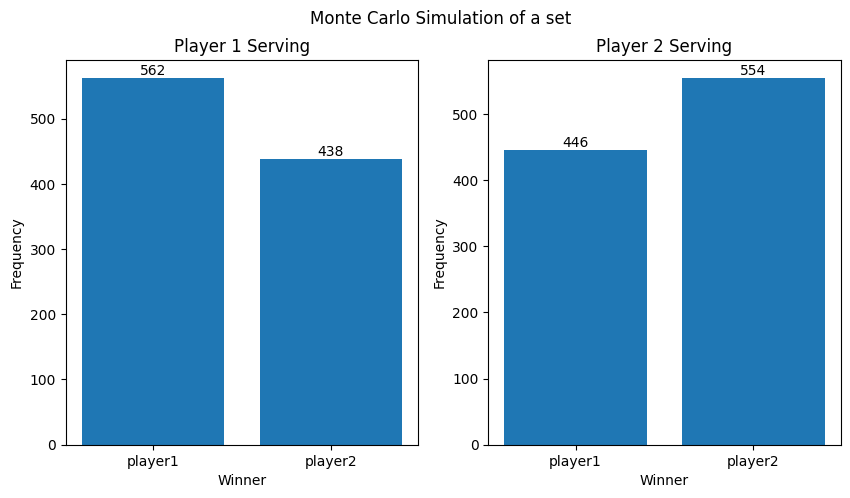

In [334]:
plot_monte_carlo_simulation(player1, player2, _monte_carlo_game)

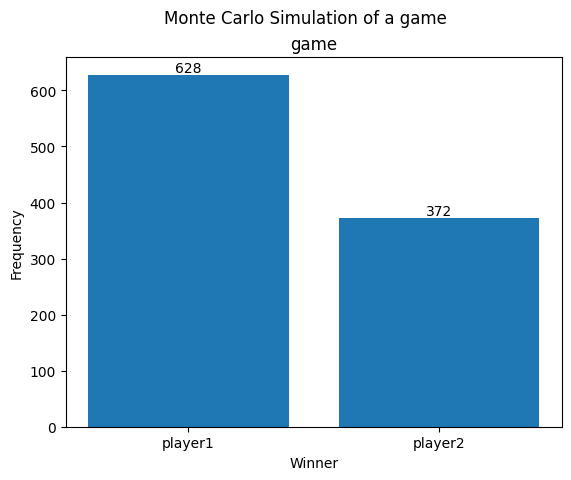

In [337]:
plot_monte_carlo_simulation(player1, player2, _monte_carlo_set)

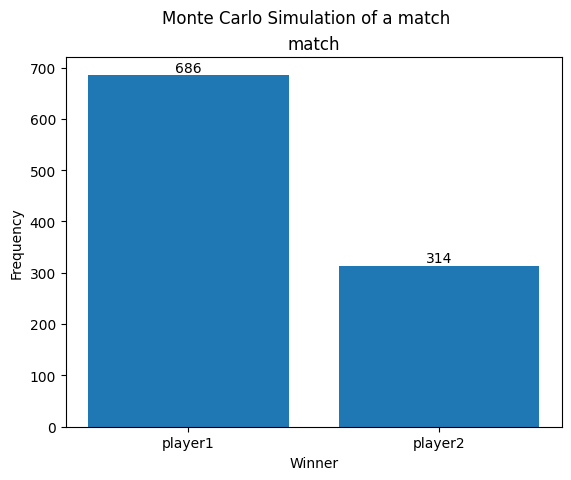

In [336]:
plot_monte_carlo_simulation(player1, player2, _monte_carlo_match)

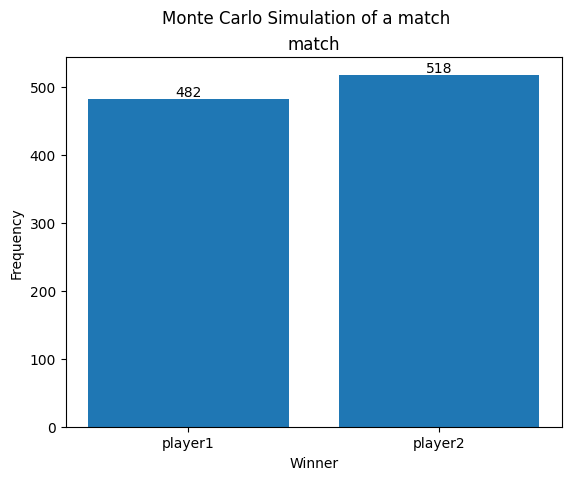

In [327]:
# plot monte carlo mathc with best of 5
plot_monte_carlo_simulation(player1, player2, lambda x, y, z: _monte_carlo_match(x, y, z, best_of=5))

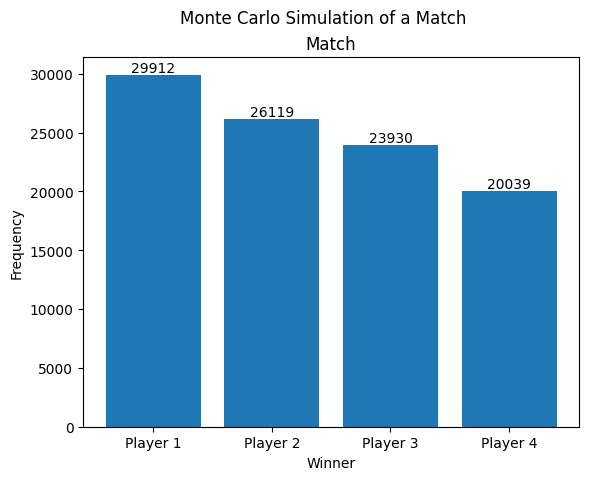

In [21]:
# showing that serve + return / 2 gives apprxiately the same result
players = np.array([
    Player(0.7, 0.8, name="Player 1"),
    Player(0.9, 0.4, name="Player 2"),
    Player(0.6, 0.6, name="Player 3"),
    Player(0.5, 0.5, name="Player 4"),
])

player_skill_level = [((p.Serve + p.Return) / 2) for p in players]

p=proportional_scaling(player_skill_level)
sims=100000
winners = {
    p.name: 0 for p in players
}

for i in range(sims):
    winner = players[np.random.choice(range(len(players)), p=p)]
    winners[winner.name] += 1

fig, ax = plt.subplots()
fig.suptitle("Monte Carlo Simulation of a Match")
ax.bar(winners.keys(), winners.values())
ax.bar_label(ax.containers[0])
ax.set_title("Match")
ax.set_xlabel("Winner")
ax.set_ylabel("Frequency")
plt.show()


Running a long montecarlo simulation for points show that there are results where players with lower skill levels also occasionally win as shown below. 
This analysis shows that a longer match is more effective in revealing the true quality of players as it allows for more points to be played and hence more opportunities for the player with the higher skill level to win.

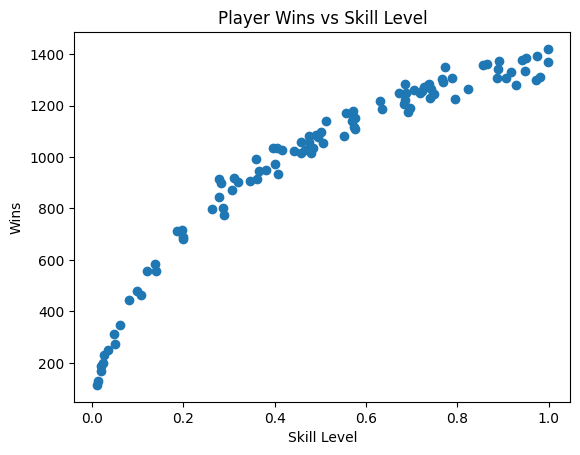

In [345]:
simulations = 100000
players = []
for i in range(100):
    player_skill_level = np.random.random()
    players.append((i, player_skill_level))

winners = []
for _ in range(simulations):
    p1, p2 = np.random.choice(range(100), size=2)
    # the winner is decided by a random choice based on the skill level
    winner = np.random.choice([p1, p2], p=proportional_scaling([players[p1][1], players[p2][1]]))
    # winner = np.random.choice(range(100), p=probabilities)
    winners.append(winner)

plt.scatter([p[1] for p in players], [winners.count(i) for i in range(100)])
plt.xlabel("Skill Level")
plt.ylabel("Wins")
plt.title("Player Wins vs Skill Level")
plt.show()

### Heuristics simulation

#### Heuristics - simulated annealing technique

Using the metropolis criterion for maximising f(x)

Given that tennis is a game that incorporates both these skills, the total skill level of a player is somewhere around the average of these skills. 

##### The perturb function
$$
perturb(players) = \text{swap 2 random players}
$$

##### Heuristic evaulation

$$
\Delta skill = \sum_{i=1}^{N} (Serve_{S'[i]} + Return_{S'[i]}) - \sum_{i=1}^{N} (Serve_{S[i]} + Return_{S[i]})
$$

##### Metropolis criterion / acceptance probability

$$
\text{Accept with probabaility} = 
\begin{cases}
    1 & \text{if} \Delta skill> 0 \\
    e^{\frac{-\Delta skill}{T}} & \text{otherwise}
\end{cases}
$$

##### Cooling process

$$
T_{new} = T_{old} \times \alpha
$$


In [346]:
def perturb(players):
    i, j = np.random.choice(range(len(players)), 2, replace=False)
    new_players = np.copy(players)
    new_players[i], new_players[j] = new_players[j], new_players[i]
    return new_players

def heuristic_simulate_tournament(players, t0, cooling_factor, perturbations=1000):
    players = np.array(players)
    number_of_players = len(players)
    current_solution = np.random.permutation(players)
    t = t0
    while t > 0.001:
        for _ in range(perturbations):
            new_solution = perturb(current_solution)
            delta = np.sum([new_solution[i]["Serve"] + new_solution[i]["Return"] - current_solution[i]["Serve"] - current_solution[i]["Return"] for i in range(number_of_players)])
            if delta > 0 or np.random.random() < np.exp(-delta / t):
                current_solution = new_solution
        t *= cooling_factor

    return current_solution

players = np.array([
    Player(0.7, 0.8),
    Player(0.6, 0.6),
    Player(0.9, 0.4),
    Player(0.5, 0.5),
    Player(0.9, 0.2),
    Player(0.1, 0.9),
    Player(0.9, 0.4),
    Player(0.1, 0.1),
])

result = heuristic_simulate_tournament(players, 100, 0.95)
for i, player in enumerate(result):
    print(f"Rank {i+1}: {player.name} : Serve={player.Serve} : Return={player.Return}")

Rank 1:  : Serve=0.9 : Return=0.4
Rank 2:  : Serve=0.9 : Return=0.2
Rank 3:  : Serve=0.1 : Return=0.9
Rank 4:  : Serve=0.5 : Return=0.5
Rank 5:  : Serve=0.6 : Return=0.6
Rank 6:  : Serve=0.9 : Return=0.4
Rank 7:  : Serve=0.7 : Return=0.8
Rank 8:  : Serve=0.1 : Return=0.1


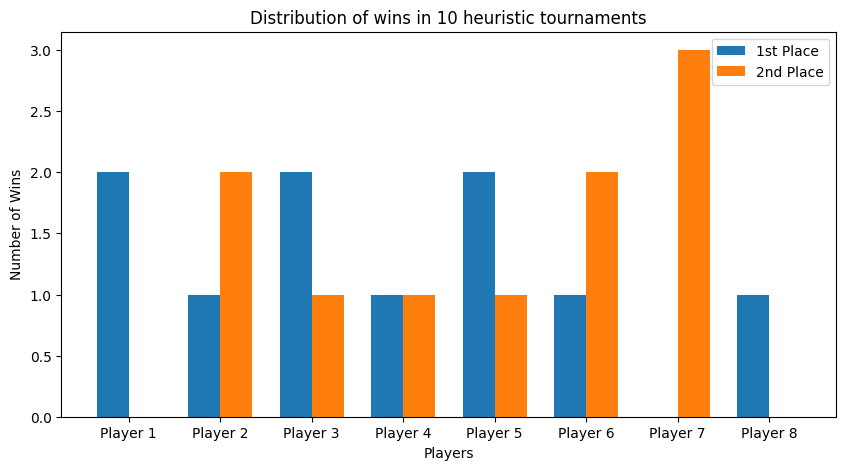

In [24]:
# run heuristic simulation 100 times and plot
def simulate_heuristic_tournament(players, t0, cooling_factor, perturbations=100, num_simulations=10):
    first_place = []
    second_place = []
    # set player names
    for i, player in enumerate(players):
        player["name"] = f"Player {i + 1}"

    for _ in range(num_simulations):
        result = heuristic_simulate_tournament(players, t0, cooling_factor, perturbations)
        first_place.append(result[0])
        second_place.append(result[1])

    stats_first_place = get_stats(players, first_place)
    stats_second_place = get_stats(players, second_place)

    fig, ax = plt.subplots()
    # increase figure size to show all player names
    fig.set_size_inches(10, 5)
    bar_width = 0.35
    index = np.arange(len(players))
    ax.bar(index, stats_first_place.values(), bar_width, label="1st Place")
    ax.bar(index + bar_width, stats_second_place.values(), bar_width, label="2nd Place")
    ax.set_xlabel("Players")
    ax.set_ylabel("Number of Wins")
    ax.set_title(f"Distribution of wins in {num_simulations} heuristic tournaments")
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(stats_first_place.keys())
    ax.legend()
    plt.show()
        
    
simulate_heuristic_tournament(players, 100, 0.95)

## Section 5: List of algorithms and concepts

### Markov chains - how it plays a role in my model

Markov chains are used to model the probability of transitioning from one state to another before being absorbed into one of the absorbing states. 
In my model the markov chains are primarily used to determine the probability of a player winning a point based on their skill level and forms the basis of the simulation. 
I used markov chains because because I believed that the next state is a probabilistic function of the current state and not the entire history of the match. This is important as it allows me to focus on the skill level of the player and not the strategies that they might use in a match.
This also implies that the skill level takes into account other factors such as fitness, mental strength, etc. which are important in a tennis match.

While not attempted here, it could've been used to determine other qualities that tennis players exhibit and to refine the skill levels further. For example, if 2 players are able to maintain a rally for a certain amount of time, this could indicate a higher skill level. 

### Monte Carlo simulations - how it plays a role in my model

In order to understand the general trends created by the skill distribution in the model, I used montecarlo simulations. This allowed me to run the simulation multiple times and understand the general trends that are created by the skill distribution.

### Heuristics - simulated annealing technique - how it plays a role in my model

From the previous analysis, it was observed that for Single Elimination format tournaments the initial order of players matters. Some amount of randomness gives more players the opportunity to progress further in the tournament.
Heuristics can help to anlyse how players with different skill levels might perform in the tournament and understand the general win distribution.